In [27]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib import font_manager as fm
from cycler import cycler
import numpy as np
from math import sqrt, pi, exp
from scipy.stats import norm
from scipy.integrate import quad
from tools import load, split, estimate_derivative, pseudoderivative, whiten
import numpy as np
from scipy.stats import pearsonr

In [49]:
a = np.array([4,2,3,1,0])
np.argsort(a)

array([4, 3, 1, 2, 0])

In [28]:
def _phi(x):
    return (1.0 / sqrt(2.0 * pi)) * exp(-0.5 * x * x)

def K(r, s, atol=1e-12, rtol=1e-10):
    """
    Stable K(r, s) using Mehler's formula + numerical quadrature.
    Valid for -1 < r <= 1 (clip r just below 1 for numerical safety).
    """
    if not (0.0 < s < 1.0):
        raise ValueError("s must be in (0,1).")

    # keep r in (-1, 1); allow r=1 by integrating to 1-eps
    r = float(r)
    if r >= 1.0:
        r = np.nextafter(1.0, 0.0)
    if r <= -1.0:
        r = np.nextafter(-1.0, 0.0)

    t = float(norm.ppf(s))
    phi_t = _phi(t)
    scale = (phi_t / (1.0 - s))**2

    def S(u):
        # integrand from Mehler (probabilists' Hermite)
        return (1.0 / np.sqrt(1.0 - u*u)) * np.exp((t*t) * (u / (1.0 + u)))

    I, err = quad(S, 0.0, r, epsabs=atol, epsrel=rtol, limit=200)
    return (1.0 - s) + scale * I

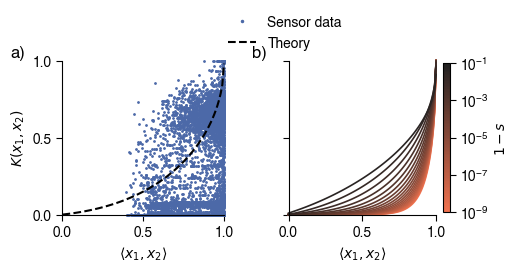

In [46]:
n_hd = 10000
n_out = 3
k = 200
n_train = 450
s = 1 - k/n_hd
n_pairs = 10000

filename = '1_600_20'

sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(pseudoderivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))
# sensor_data = whiten(sensor_data)

x_dense = sensor_data
row_norms = np.linalg.norm(x_dense, axis=1, keepdims=True)
x_dense = x_dense / row_norms

n_dense = x_dense.shape[1]

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec[:n_train]):
    try:
        flag = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i])
    labels[flag] = int(sequence[i][1])

idx_first_flag = np.where(labels != 0)[0][0]
# idx_last_flag = np.where(labels != 0)[0][-1]

W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
x_hd = x_dense @ W_hd.T
ranks = np.argsort(np.argsort(x_hd, axis=1), axis=1)
z_hd = np.where(ranks < k, 1., 0.)
x = []
y = []

x_dense = x_dense[idx_first_flag:]
z_hd = z_hd[idx_first_flag:]

for i in range(n_pairs):
    idx1, idx2 = np.random.choice(z_hd.shape[0], size=2, replace=False)
    x.append(np.dot(x_dense[idx1], x_dense[idx2])/(np.linalg.norm(x_dense[idx1])*np.linalg.norm(x_dense[idx2])))
    y.append(np.dot(z_hd[idx1], z_hd[idx2])/k)


rs = np.arange(0, 1.01, 0.01)
vals = [K(r=ri, s=s)*(1-s) for ri in rs]
# graded_cmap = LinearSegmentedColormap.from_list('green_to_dark', ["#269f30", "#1d1d1d"], N=100)
# graded_cmap = LinearSegmentedColormap.from_list('red_to_dark', ["#c23232", "#1d1d1d"], N=100)
cm = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
graded_cmap = LinearSegmentedColormap.from_list('red_to_dark', [cm.colors[1], cm.colors[4]], N=100)



fig, ax = plt.subplots(1, 2, figsize=(5,2), gridspec_kw={'wspace': 0.4})
ax0 = ax[0]
ax1 = ax[1]

ax0.plot(x, y, '.', alpha=1., ms=2, clip_on=False, label='Sensor data')
ax0.plot(rs, vals, '--', color='black', linewidth=1.5, clip_on=False, label='Theory')
ax0.set_ylabel(r'$K({x}_{1}, {x}_{2})$')
ax0.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
ax0.legend(bbox_to_anchor=(0.95, 0.99), frameon=False, fontsize=10,
          markerscale=1.5)
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])

density = np.logspace(-9, -1, 20)
rs = np.arange(0, 1.01, 0.01)
# Normalize in log space so color matches density values
norma = LogNorm(vmin=density.min(), vmax=density.max())
sm = ScalarMappable(norm=norma, cmap=graded_cmap)  # mappable for colorbar

for i, d in enumerate(density):
    s = 1 - d
    vals = [K(r=ri, s=s)*(1-s) for ri in rs]
    ax1.plot(rs, vals, color=graded_cmap(int((100./len(density))*i)), clip_on=False,)

# Add colorbar for the right subplot
cbar = fig.colorbar(sm, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('$1-s$')
cbar.set_ticks([1e-9, 1e-7, 1e-5, 1e-3, 1e-1])

ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xticks([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1], labels=[])
ax1.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')

ax0.text(-0.23, 1., 'a)', transform=ax0.transAxes,
         fontsize=12, ha='right', va='bottom')
ax1.text(-0.15, 1., 'b)', transform=ax1.transAxes,
         fontsize=12, ha='right', va='bottom')

plt.savefig('figs/kernel_shape.pdf', bbox_inches='tight')
plt.savefig('figs/kernel_shape.png', bbox_inches='tight', dpi=300)

plt.show()

In [33]:
k_sweep = [10, 30, 90, 270]
p_sweep = [0.01, 0.03, 0.05, 0.07]
n_pairs = 10000


x_array = np.zeros((len(k_sweep), len(p_sweep), n_pairs))
y_array = np.zeros((len(k_sweep), len(p_sweep), n_pairs))
rs = np.arange(0, 1.01, 0.01)

for j, k in enumerate(k_sweep):
    for l, p in enumerate(p_sweep):

        W_hd = np.random.binomial(n=1, p=p, size=(n_hd, n_dense))  #Test random sparse weights
        x_hd = x_dense @ W_hd.T
        ranks = np.argsort(np.argsort(x_hd, axis=1), axis=1)
        z_hd = np.where(ranks < k, 1., 0.)

        x = []
        y = []

        for i in range(n_pairs):
            idx1, idx2 = np.random.choice(z_hd.shape[0], size=2, replace=False)
            x.append(np.dot(x_dense[idx1], x_dense[idx2])/(np.linalg.norm(x_dense[idx1])*np.linalg.norm(x_dense[idx2])))
            y.append(np.dot(z_hd[idx1], z_hd[idx2])/k)

        x_array[j, l] = x
        y_array[j, l] = y

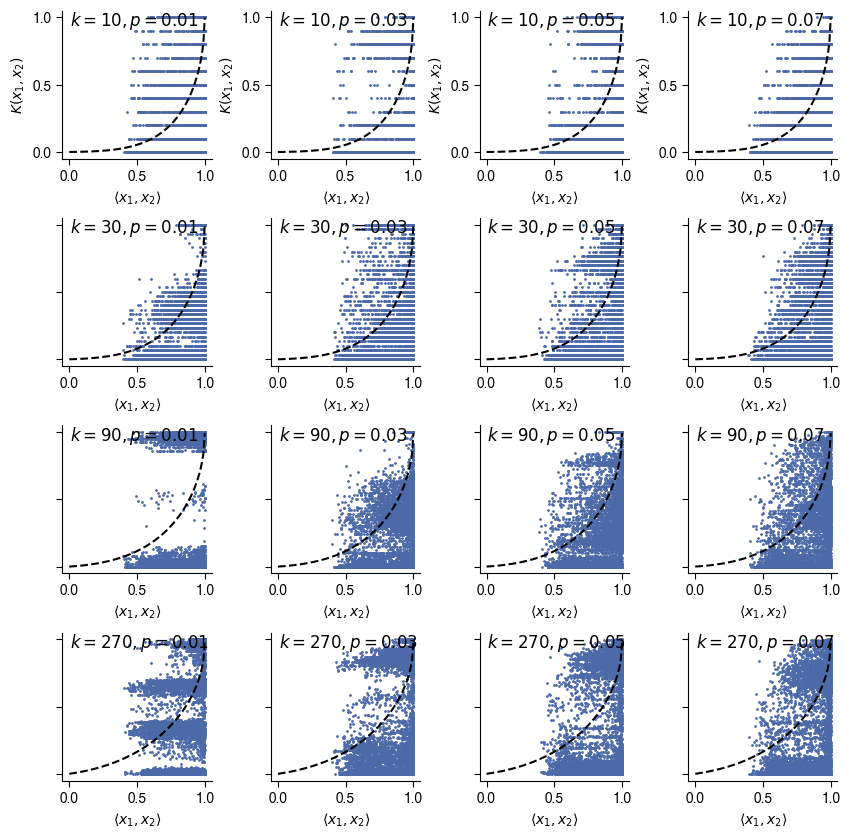

In [34]:
fig, ax = plt.subplots(len(k_sweep), len(p_sweep), figsize=(10,10), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

for i, k in enumerate(k_sweep):
    s = 1 - k/n_hd
    vals = [K(r=ri, s=s)*(1-s) for ri in rs]
    for j, k in enumerate(p_sweep):
        x = x_array[i, j]
        y = y_array[i, j]

        ax[i, j].plot(x, y, '.', alpha=1., ms=2, clip_on=False, label='Sensor data', color='C0')
        ax[i, j].plot(rs, vals, '--', color='black', linewidth=1.5, clip_on=False, label='Theory')
        ax[i, j].set_ylabel(r'$K({x}_{1}, {x}_{2})$')
        ax[i, j].set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
        #x[i, j] a.legend(bbox_to_anchor=(0.95, 0.99), frameon=False, fontsize=10,
        #x[i, j]    markerscale=1.5)
        # ax[i, j].set_xlim(0,1)
        # ax[i, j].set_ylim(0,1)
        ax[i, j].set_xticks([0, 0.5, 1])
        ax[i, j].set_yticks([0, 0.5, 1])
        ax[i, j].text(0.05, 0.9, f'$k={k_sweep[i]}, p={p_sweep[j]}$', transform=ax[i, j].transAxes)
        if i != 0:
            ax[i, j].set_yticks([0, 0.5, 1], labels=[])
            ax[i, j].set_ylabel('')

# plt.savefig('figs/kernel_shape.pdf', bbox_inches='tight')
plt.show()

In [22]:
k_sweep = [50, 100, 200, 400]

x_list = []
y_list = []
vals_list = []

rs = np.arange(0, 1.01, 0.01)

for k in k_sweep:
    s = 1 - k/n_hd

    W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
    x_hd = x_dense @ W_hd.T
    ranks = np.argsort(np.argsort(-x_hd, axis=1), axis=1)
    z_hd = np.where(ranks < k, 1., 0.)

    n_pairs = 10000

    x = []
    y = []

    for i in range(n_pairs):
        idx1, idx2 = np.random.choice(z_hd.shape[0], size=2, replace=False)
        x.append(np.dot(x_dense[idx1], x_dense[idx2])/(np.linalg.norm(x_dense[idx1])*np.linalg.norm(x_dense[idx2])))
        y.append(np.dot(z_hd[idx1], z_hd[idx2])/k)

    x_list.append(x)
    y_list.append(y)

    vals = [K(r=ri, s=s)*(1-s) for ri in rs]
    vals_list.append(vals)

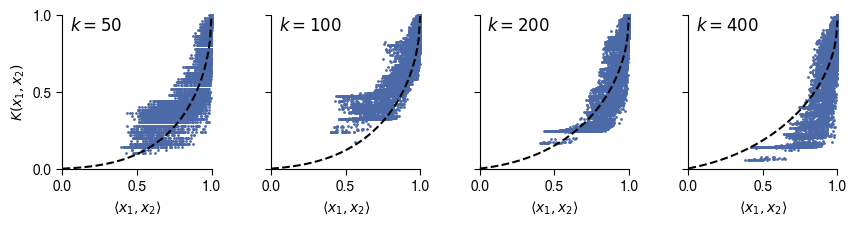

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(10,2), gridspec_kw={'wspace': 0.4})

for i,a in enumerate(ax.flatten()):
    x = x_list[i]
    y = y_list[i]
    vals = vals_list[i]
    a.plot(x, y, '.', alpha=1., ms=2, clip_on=False, label='Sensor data')
    a.plot(rs, vals, '--', color='black', linewidth=1.5, clip_on=False, label='Theory')
    a.set_ylabel(r'$K({x}_{1}, {x}_{2})$')
    a.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
    # a.legend(bbox_to_anchor=(0.95, 0.99), frameon=False, fontsize=10,
    #    markerscale=1.5)
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    a.set_xticks([0, 0.5, 1])
    a.set_yticks([0, 0.5, 1])
    a.text(0.05, 0.9, f'$k={k_sweep[i]}$', transform=a.transAxes)
    if i != 0:
        a.set_yticks([0, 0.5, 1], labels=[])
        a.set_ylabel('')

# plt.savefig('figs/kernel_shape.pdf', bbox_inches='tight')
plt.show()

In [24]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist['data'].astype(np.float32)   # shape (70000, 784)
Y = mnist['target'].astype(np.int64)   # shape (70000,)

In [25]:
n_hd = 10000
k = 500
n_pairs = 10000

filename = 'mix_100_20_1'

sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(pseudoderivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))

x_dense = sensor_data
row_norms = np.linalg.norm(x_dense, axis=1, keepdims=True)
x_dense = x_dense / row_norms

W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, x_dense.shape[1]))  #Test random sparse weights
x_hd = x_dense @ W_hd.T
ranks = np.argsort(np.argsort(-x_hd, axis=1), axis=1)
z_hd = np.where(ranks < k, 1., 0.)

x = []
y = []

for i in range(n_pairs):
    idx1, idx2 = np.random.choice(z_hd.shape[0], size=2, replace=False)
    x.append(np.dot(x_dense[idx1], x_dense[idx2]) / (np.linalg.norm(x_dense[idx1]) * np.linalg.norm(x_dense[idx2])))
    # y.append(np.dot(z_hd[idx1], z_hd[idx2]) / k)
    y.append(np.dot(z_hd[idx1], z_hd[idx2]) / (np.linalg.norm(z_hd[idx1]) * np.linalg.norm(z_hd[idx2])))

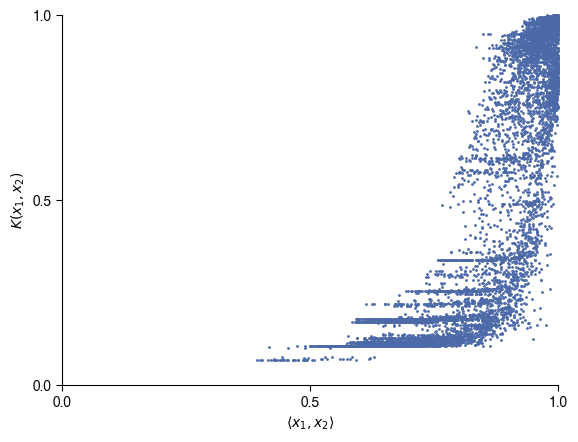

In [26]:
# graded_cmap = LinearSegmentedColormap.from_list('green_to_dark', ["#269f30", "#1d1d1d"], N=100)
# graded_cmap = LinearSegmentedColormap.from_list('red_to_dark', ["#c23232", "#1d1d1d"], N=100)
cm = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
graded_cmap = LinearSegmentedColormap.from_list('red_to_dark', [cm.colors[1], cm.colors[4]], N=100)

fig, ax = plt.subplots(1, 1)
ax0 = ax
ax0.plot(x, y, '.', alpha=1., ms=2, clip_on=False)
ax0.set_ylabel(r'$K({x}_{1}, {x}_{2})$')
ax0.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
ax0.set_xlim(0, 1)
ax0.set_ylim(0, 1)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])

plt.show()